<a href="https://colab.research.google.com/github/KORALLLL/MTUCI_EMNIST/blob/main/lenet/Korallll_lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lenet configuration on custom dataset with normalizeing data

<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>5*5</th>
    <th>1</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>2</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>3</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>5*5</th>
    <th>1</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>4</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>5</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>6</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>

train dataset: MNIST + EMNIST letters

test dataset: dataset of DreamTeam

training sample size: 36960

testing sample size: 16784

loss finction: Cross Entropy Loss

optimizer: adam

learning rate: 0.001

batch size: 1120

epoch number: 100


## module importation

In [1]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as bar
import pickle
import numpy as np

## git cloning

In [2]:
!git clone https://github.com/KORALLLL/MTUCI_EMNIST.git

Cloning into 'MTUCI_EMNIST'...
remote: Enumerating objects: 36354, done.
remote: Counting objects: 100% (12714/12714), done.
remote: Compressing objects: 100% (12599/12599), done.
remote: Total 36354 (delta 123), reused 12685 (delta 113), pack-reused 23640
Receiving objects: 100% (36354/36354), 126.00 MiB | 31.86 MiB/s, done.
Resolving deltas: 100% (408/408), done.


##dataset preparation

In [6]:
emnist_train = torchvision.datasets.EMNIST('./', split='letters', download = True, train = True)
mnist_train = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = True)
emnist_val = torchvision.datasets.EMNIST('./', split='letters', download = True, train = False)
mnist_val = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

emnist_train_data = emnist_train.data
mnist_train_data = mnist_train.data
train_data = torch.cat([emnist_train_data[:24960], mnist_train_data[:12000]], dim=0).float().unsqueeze(1).to(device) / 255

emnist_val_data = emnist_val.data
mnist_val_data = mnist_val.data
val_data = torch.cat([emnist_val_data, mnist_val_data], dim=0).float().unsqueeze(1).to(device) / 255

temp_emnist_train_labels = emnist_train.targets[:24960]
emnist_train_labels = []

temp_emnist_val_labels = emnist_val.targets
emnist_val_labels = []

for i in range(len(temp_emnist_train_labels)):
  if temp_emnist_train_labels[i]==15:
    emnist_train_labels.append(torch.tensor(0))
  elif temp_emnist_train_labels[i]>15:
    emnist_train_labels.append(temp_emnist_train_labels[i]+8)
  else:
    emnist_train_labels.append(temp_emnist_train_labels[i]+9)

for i in range(len(temp_emnist_val_labels)):
  if temp_emnist_val_labels[i]==15:
    emnist_val_labels.append(torch.tensor(0))
  elif temp_emnist_val_labels[i]>15:
    emnist_val_labels.append(temp_emnist_val_labels[i] + 8)
  else:
    emnist_val_labels.append(temp_emnist_val_labels[i]+9)

mnist_train_labels = mnist_train.targets
train_labels = torch.cat([torch.stack(emnist_train_labels[:24960]), mnist_train_labels[:12000]], dim=0).to(device)

mnist_val_labels = mnist_val.targets
val_labels = torch.cat([torch.stack(emnist_val_labels), mnist_val_labels], dim=0).to(device)


file = open('MTUCI_EMNIST/dataset.pkl', 'rb')
test_dataset = pickle.load(file)
file.close()

test_data = test_dataset['data'].numpy()
test_data = np.flip(test_data, axis = 3)
test_data = np.rot90(test_data, k=1, axes=(2,3))
test_data = 1 - test_data
test_data = torch.from_numpy(test_data).float().to(device)
test_labels = test_dataset['targets'].to(device)

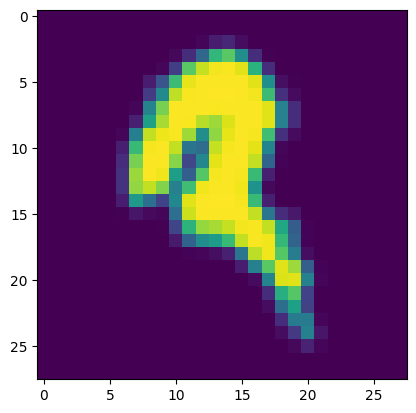

In [7]:
plt.imshow(val_data[0][0].cpu())

## configuration net

In [29]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
    self.act1 = torch.nn.Tanh()
    self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    self.act2 = torch.nn.Tanh()
    self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
    self.act3 = torch.nn.Tanh()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    self.act4=torch.nn.Tanh()
    self.fc1 = torch.nn.Linear(5*5*16,120)
    self.act5=torch.nn.Tanh()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act6 = torch.nn.Tanh()
    self.fc3 = torch.nn.Linear(84, 35)

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)
    x = self.act2(x)
    x = self.conv2(x)
    x = self.act3(x)
    x = self.pool2(x)
    x = self.act4(x)

    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act5(x)
    x = self.fc2(x)
    x = self.act6(x)
    x = self.fc3(x)
    return x
lenet = LeNet().to(device)

## initializing loss finction and optimizer

In [30]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)

## initializing arrays of metrics

In [31]:
train_accuracy_history = []
val_accuracy_history = []
test_accuracy_history = []
train_loss_history = []
val_loss_history = []
test_loss_history = []

## learning stage

In [32]:
batch_size = 1120

for epoch in bar(range(100), desc = 'learning'):
  order = np.random.permutation(len(train_data))

  for start_index in range(0, len(train_data), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index+batch_size]

    data_batch = train_data[batch_indexes].to(device)
    label_batch = train_labels[batch_indexes].to(device)

    preds = lenet.forward(data_batch)

    loss_val = loss(preds, label_batch)
    loss_val.backward()

    optimizer.step()

  train_preds = lenet.forward(train_data)
  val_preds = lenet.forward(val_data)
  test_preds = lenet.forward(test_data)

  train_loss_history.append(loss(train_preds, train_labels).data.cpu())
  val_loss_history.append(loss(val_preds, val_labels).data.cpu())
  test_loss_history.append(loss(test_preds, test_labels).data.cpu())

  train_accuracy = (train_preds.argmax(dim=1)==train_labels).float().mean().data.cpu()
  val_accuracy = (val_preds.argmax(dim=1)==val_labels).float().mean().data.cpu()
  test_accuracy = (test_preds.argmax(dim=1)==test_labels).float().mean().data.cpu()

  train_accuracy_history.append(train_accuracy)
  val_accuracy_history.append(val_accuracy)
  test_accuracy_history.append(test_accuracy)

<ipython-input-32-5549ef1b02f5>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in bar(range(100), desc = 'learning'):


learning:   0%|          | 0/100 [00:00<?, ?it/s]

## accuracy plot

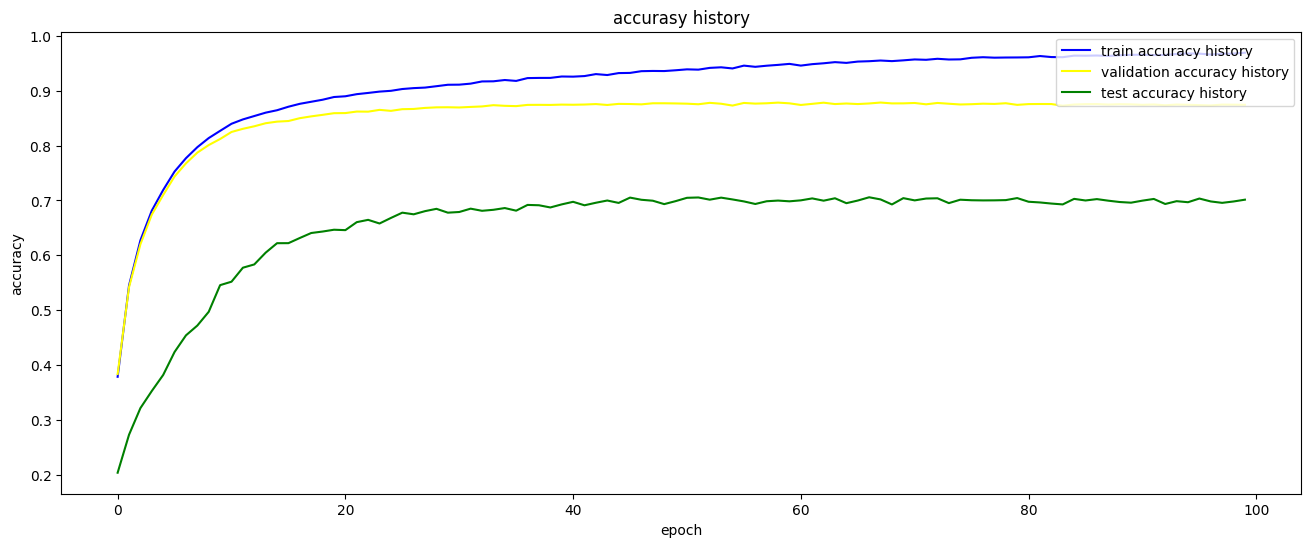

In [33]:
plt.figure(figsize=(16.0, 6.0))
plt.plot(range(len(train_accuracy_history)), train_accuracy_history, c='blue', label='train accuracy history')
plt.plot(range(len(train_accuracy_history)), val_accuracy_history, c = 'yellow', label = 'validation accuracy history')
plt.plot(range(len(train_accuracy_history)), test_accuracy_history, c='green', label='test accuracy history')
plt.title('accurasy history')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper right')

## loss plot

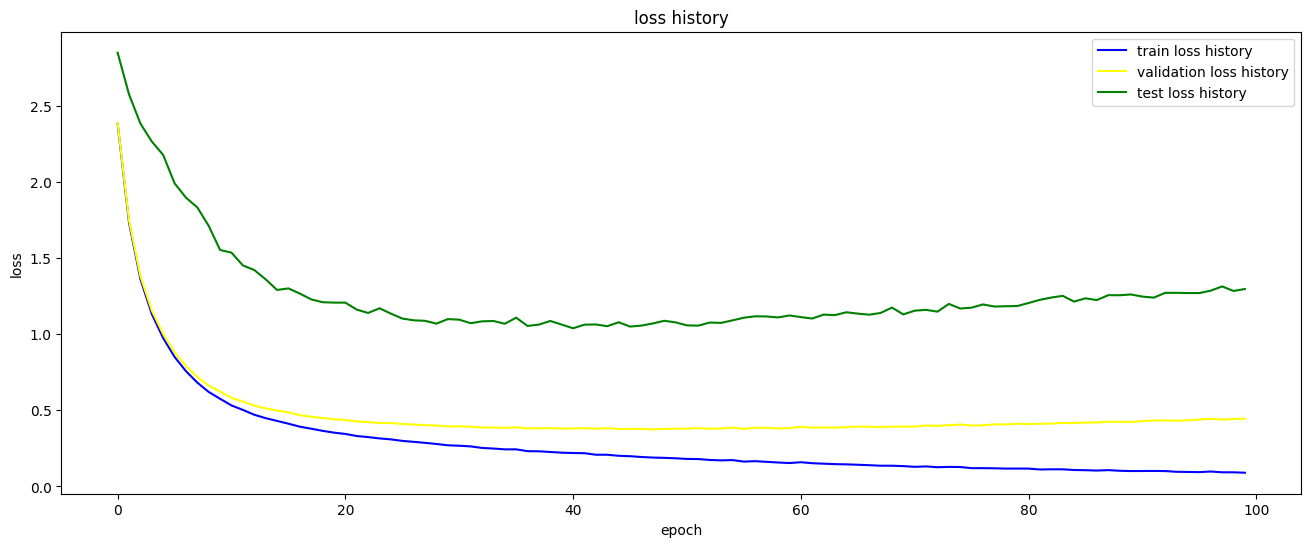

In [34]:
plt.figure(figsize=(16.0, 6.0))
plt.plot(range(len(train_loss_history)), train_loss_history, c='blue', label='train loss history')
plt.plot(range(len(train_loss_history)), val_loss_history, c = 'yellow', label = 'validation loss history')
plt.plot(range(len(train_loss_history)), test_loss_history, c='green', label='test loss history')
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')